# Mission 1: Create a AI Model
Description
Download the “Monatszahlen Verkehrsunfälle” Dataset from the München Open Data Portal. Here you see the number of accidents for specific categories per month. Important are the first 5 columns:
* Category
* Accident-type (insgesamt means total for all subcategories)
* Year
* Month
* Value

Your goal would be to visualise historically the number of accidents per category (column1). The dataset currently contains values until the end of 2020. Create an application that forecasts the values for:

* Category: 'Alkoholunfälle'
* Type: 'insgesamt
* Year: '2021'
* Month: '01'


Note: There has been recently some update on the data shared with you for the AI Engineering Challenge. The dataset has recently been updated and includes values until 2021. You should drop the records which come after 2020 for developing the prediction model. If you are interested, you can compute the error between your prediction values and the actual numbers (ground truth data).

## 1. Loading the Data

In [1]:
import pandas as pd

### LOADING THE DATA IN DATAFRAME
df = pd.read_csv('monatszahlen2412_verkehrsunfaelle_06_12_24.csv')
df.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['MONATSZAHL', 'AUSPRAEGUNG', 'JAHR', 'MONAT', 'WERT', 'VORJAHRESWERT',
       'VERAEND_VORMONAT_PROZENT', 'VERAEND_VORJAHRESMONAT_PROZENT',
       'ZWOELF_MONATE_MITTELWERT'],
      dtype='object')

Filtering the dataset for the desired category

```
Category: 'Alkoholunfälle'
Type: 'insgesamt
```

Because we have to make predictions for this category in the end

In [ ]:
# Filter for the desired category and type
mask = (df['MONATSZAHL'] == 'Alkoholunfälle') & (df['AUSPRAEGUNG'] == 'insgesamt')
df_filtered = df[mask].copy()

In [5]:
df_filtered.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT
0,Alkoholunfälle,insgesamt,2024,202401,NaN,NaN,NaN,NaN,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN,NaN,NaN,NaN,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN,NaN,NaN,NaN,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN,NaN,NaN,NaN,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN,NaN,NaN,NaN,NaN


## 2. Preprocessing The Data

We only want rows where the 'MONAT' is in the form 'YYYYMM' (not 'Summe')

Why?

The 'MONAT' column contains values like '202201', '202202', etc., representing specific months in the format 'YYYYMM' (e.g., January 2022 is '202201').   

However, some rows have 'MONAT' values like 'Summe', which represent aggregate data (e.g., total accidents for the year 2022).

Time series forecasting models, such as ARIMA or SARIMA, require consistent and uniformly spaced data points. Including aggregate rows like 'Summe' disrupts this consistency because they don't represent the same temporal granularity as the monthly data

Aggregate or summary rows can contaminate the dataset, leading to misleading patterns. For example, the 'Summe' row aggregates all monthly data for the year, which can introduce spikes or drops that don't align with the actual monthly trends.

In [6]:
df_filtered = df_filtered[df_filtered['MONAT'].apply(lambda x: str(x).isdigit())]
df_filtered['MONAT'] = df_filtered['MONAT'].astype(str)

# Extract year and month
df_filtered['year'] = df_filtered['JAHR'].astype(int)
df_filtered['month'] = df_filtered['MONAT'].str[-2:].astype(int)

df_filtered['date'] = pd.to_datetime(df_filtered['year'].astype(str) + '-' + df_filtered['month'].astype(str) + '-01')

df_filtered = df_filtered.sort_values('date')

# Ensure 'WERT' is numeric and handle missing values
df_filtered['WERT'] = pd.to_numeric(df_filtered['WERT'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['WERT'])

df_filtered.set_index('date', inplace=True)

df_filtered.head()

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,year,month
date,,,,,,,,,,,
2000-01-01,Alkoholunfälle,insgesamt,2000,200001,78.0,NaN,NaN,NaN,78.0,2000,1
2000-02-01,Alkoholunfälle,insgesamt,2000,200002,53.0,NaN,-32.05,NaN,66.0,2000,2
2000-03-01,Alkoholunfälle,insgesamt,2000,200003,73.0,NaN,37.74,NaN,68.0,2000,3
2000-04-01,Alkoholunfälle,insgesamt,2000,200004,78.0,NaN,6.85,NaN,71.0,2000,4
2000-05-01,Alkoholunfälle,insgesamt,2000,200005,96.0,NaN,23.08,NaN,76.0,2000,5


In [ ]:
# Detect and Handle Outliers
# Using the IQR method to detect outliers
Q1 = df_filtered['WERT'].quantile(0.25)
Q3 = df_filtered['WERT'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_filtered[(df_filtered['WERT'] < lower_bound) | (df_filtered['WERT'] > upper_bound)]
print("\nDetected Outliers:")
outliers


Detected Outliers:


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,year,month
date,,,,,,,,,,,
2000-05-01,Alkoholunfälle,insgesamt,2000,200005,96.0,NaN,23.08,NaN,76.0,2000,5
2000-07-01,Alkoholunfälle,insgesamt,2000,200007,99.0,NaN,73.68,NaN,76.0,2000,7
2001-09-01,Alkoholunfälle,insgesamt,2001,200109,107.0,84.0,78.33,27.38,73.0,2001,9
2002-09-01,Alkoholunfälle,insgesamt,2002,200209,107.0,107.0,50.70,0.00,69.0,2002,9


In [12]:
import numpy as np

# Replace outliers with capped values (capping)
df_filtered['WERT'] = np.where(
    df_filtered['WERT'] < lower_bound,
    lower_bound,
    np.where(
        df_filtered['WERT'] > upper_bound,
        upper_bound,
        df_filtered['WERT']
    )
)

In [13]:
df_filtered.loc[outliers.index]

,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,year,month
date,,,,,,,,,,,
2000-05-01,Alkoholunfälle,insgesamt,2000,200005,87.5,NaN,23.08,NaN,76.0,2000,5
2000-07-01,Alkoholunfälle,insgesamt,2000,200007,87.5,NaN,73.68,NaN,76.0,2000,7
2001-09-01,Alkoholunfälle,insgesamt,2001,200109,87.5,84.0,78.33,27.38,73.0,2001,9
2002-09-01,Alkoholunfälle,insgesamt,2002,200209,87.5,107.0,50.70,0.00,69.0,2002,9


Stationarity Check with Augmented Dickey-Fuller Test

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    """
    Perform Augmented Dickey-Fuller test and print results.
    """
    print(f'ADF Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.\n")
    else:
        print("=> The series is non-stationary.\n")

adf_test(df_filtered['WERT'], title='Original Series')

ADF Test: Original Series
ADF Statistic            -2.723084
p-value                   0.070128
# Lags Used              13.000000
# Observations          262.000000
Critical Value (1%)      -3.455558
Critical Value (5%)      -2.872636
Critical Value (10%)     -2.572683
=> The series is non-stationary.



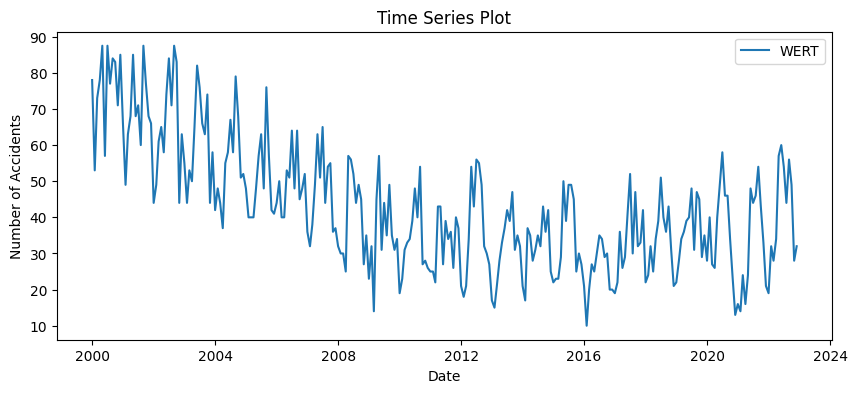

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(df_filtered['WERT'], label='WERT')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.legend()
plt.show()


## 3. Split Data into Training and Testing

In [20]:
train_end = '2020-12-31'

# Training data: up to December 2020
train_df = df_filtered[df_filtered.index <= train_end]

# Testing data: January 2021
test_df = df_filtered[df_filtered.index == '2021-01-01']

print("\nTraining Data Range:", train_df.index.min(), "to", train_df.index.max())
print("Testing Data:")
test_df


Training Data Range: 2000-01-01 00:00:00 to 2020-12-01 00:00:00
Testing Data:


,MONATSZAHL,AUSPRAEGUNG,JAHR,MONAT,WERT,VORJAHRESWERT,VERAEND_VORMONAT_PROZENT,VERAEND_VORJAHRESMONAT_PROZENT,ZWOELF_MONATE_MITTELWERT,year,month
date,,,,,,,,,,,
2021-01-01,Alkoholunfälle,insgesamt,2021,202101,16.0,28.0,23.08,-42.86,35.0,2021,1


## 4. Model Training with auto_arima

In [23]:
from pmdarima import auto_arima

train_series = train_df['WERT']

# Define seasonal period (12 for monthly data)
seasonal_period = 12

print("\nTraining the auto_arima model...")
model = auto_arima(
    train_series,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,               # Let auto_arima determine the optimal differencing
    seasonal=True,
    m=seasonal_period,
    start_P=0, start_Q=0,
    max_P=3, max_Q=3,
    D=1,                  # Seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,            # Utilize all available CPUs
    information_criterion='aic',  
    max_order=10          # Limit the maximum order to prevent excessively large models
)


Training the auto_arima model...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1882.560, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1780.071, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1691.787, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1787.324, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1693.202, Time=0.27 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1693.281, Time=0.52 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1720.510, Time=0.27 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=1695.094, Time=1.11 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1792.656, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1689.379, Time=0.26 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1777.981, Time=0.20 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1690.922, Time=0.35 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1690.973, Time=0.61 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1715.006,

## 5. Forecasting

In [25]:
n_periods = 1

forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
last_date = train_series.index[-1]
forecast_dates = pd.date_range(last_date + pd.DateOffset(months=1), periods=n_periods, freq='MS')

In [26]:
forecast_df = pd.DataFrame({
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
}, index=forecast_dates)

print("\nForecasted Values:")
forecast_df


Forecasted Values:


,Forecast,Lower CI,Upper CI
2021-01-01,20.99025,5.427628,36.552872
